In [13]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iabhishekofficial/mobile-price-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/mobile-price-classification


📊 Dataset loaded: 2000 rows × 21 columns

📋 Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 

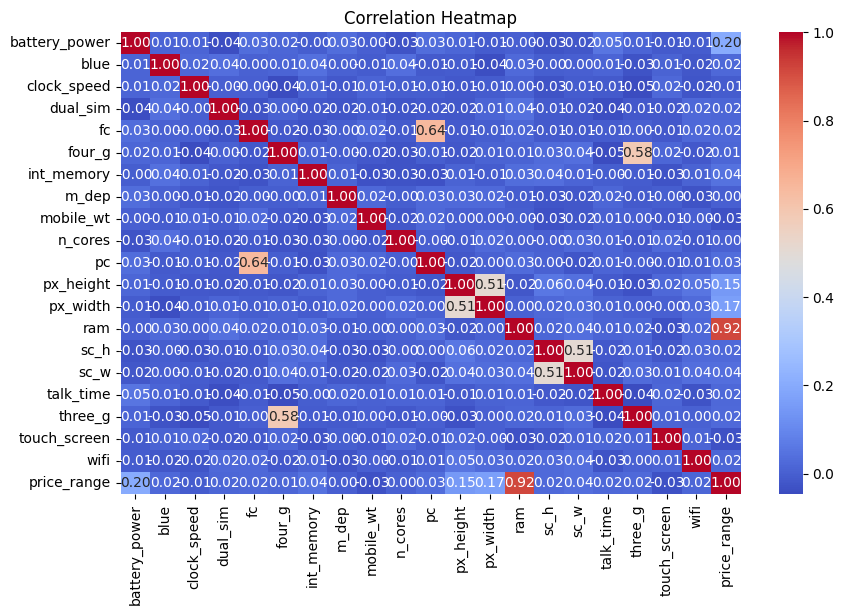

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ====== 1. Load Data ======
df = pd.read_csv("/kaggle/input/mobile-price-classification/train.csv")  # Ganti dengan nama file kamu
print(f"📊 Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")

# ====== 2. Basic Info ======
print("\n📋 Basic Info:")
print(df.info())

# ====== 3. Missing Values Check ======
print("\n🔍 Missing Values:")
missing = df.isnull().sum()
print(missing[missing > 0])

# ====== 4. Skewness Check ======
print("\n📈 Skewness Check:")
skewed_features = df.select_dtypes(include=['number']).apply(lambda x: x.skew()).sort_values(ascending=False)
print(skewed_features)

print("\n📌 Recommendation:")
for col, skew in skewed_features.items():
    if abs(skew) > 1:
        print(f"⚠️ {col} is highly skewed (skew={skew:.2f}). Suggest: Apply log or sqrt transform.")
    elif abs(skew) > 0.5:
        print(f"ℹ️ {col} is moderately skewed (skew={skew:.2f}). Transform optional.")
    else:
        print(f"✅ {col} is fairly symmetric (skew={skew:.2f}). No action needed.")

# ====== 5. Outlier Detection (IQR Method) ======
print("\n📦 Outlier Check (IQR Method):")
for col in df.select_dtypes(include=['number']):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outlier_count = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
    if outlier_count > 0:
        print(f"⚠️ {col}: {outlier_count} outliers detected.")
    else:
        print(f"✅ {col}: No significant outliers.")

# ====== 6. Correlation Analysis ======
print("\n🔗 Correlation Matrix (Top correlated pairs):")
correlation = df.corr(numeric_only=True)
cor_matrix = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()
top_corr = cor_matrix[(cor_matrix < 1) & (cor_matrix > 0.7)]
print(top_corr)

print("\n📌 Recommendation:")
for (f1, f2), corr_val in top_corr.items():
    print(f"⚠️ {f1} & {f2} have high correlation ({corr_val:.2f}). Suggest: Keep only one or apply dimensionality reduction (e.g., PCA).")

# ====== 7. Heatmap ======
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [15]:
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [16]:
train_df = pd.read_csv("/kaggle/input/mobile-price-classification/train.csv")  # ada kolom price_range
test_df = pd.read_csv("/kaggle/input/mobile-price-classification/test.csv")    # tidak ada kolom price_range (hanya fitur)

In [17]:
train_df['fc_log'] = np.log1p(train_df['fc'])
test_df['fc_log'] = np.log1p(test_df['fc'])  # penting: transformasi harus sama

In [22]:
from sklearn.preprocessing import StandardScaler

# Pisahkan fitur dan label
X_train = train_df.drop(columns=['price_range'])
y_train = train_df['price_range']
X_test = test_df.drop(columns=['id']) 

# Standarisasi
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Versi Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Inisialisasi dan training model RandomForest
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

# Prediksi pada data test
test_pred = model.predict(X_test_scaled)

# Cross-validation prediksi
y_pred_cv = cross_val_predict(model, X_train_scaled, y_train, cv=5)

print("\n📊Metrics (RandomForest - Cross-Validation)")
print("Accuracy:", accuracy_score(y_train, y_pred_cv))
print("Precision:", precision_score(y_train, y_pred_cv, average='macro'))
print("Recall:", recall_score(y_train, y_pred_cv, average='macro'))
print("F1 Score:", f1_score(y_train, y_pred_cv, average='macro'))



📊Metrics (RandomForest - Cross-Validation)
Accuracy: 0.8725
Precision: 0.8724579858098953
Recall: 0.8724999999999999
F1 Score: 0.8721778622887959


Versi XGBoost

In [28]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Inisialisasi dan training model XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Prediksi pada data test
test_pred_xgb = xgb_model.predict(X_test_scaled)

# Cross-validation prediksi
y_pred_cv_xgb = cross_val_predict(xgb_model, X_train_scaled, y_train, cv=5)

print("\n📊 Metrics (XGBoost - Cross-Validation)")
print("Accuracy:", accuracy_score(y_train, y_pred_cv_xgb))
print("Precision:", precision_score(y_train, y_pred_cv_xgb, average='macro'))
print("Recall:", recall_score(y_train, y_pred_cv_xgb, average='macro'))
print("F1 Score:", f1_score(y_train, y_pred_cv_xgb, average='macro'))



📊 Metrics (XGBoost - Cross-Validation)
Accuracy: 0.9075
Precision: 0.907781754131664
Recall: 0.9075
F1 Score: 0.9076079929531795
